<a href="https://colab.research.google.com/github/JyothyVariyampat/Benchmark-ML-and-DL-Models-for-Small-Molecule-Immunity-Target-Bioactivity-Prediction./blob/main/VanillaGNN_Optuna_Classification_AID1578.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 69.9 MB/s eta 0:00:00


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00


In [ ]:
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00


[I 2024-11-20 02:14:38,486] A new study created in memory with name: no-name-9b8ae2c5-7063-44b8-9695-5ac9a820ef5d
[I 2024-11-20 02:14:52,002] Trial 0 finished with value: 0.61625 and parameters: {'hidden_dim': 72, 'dropout_rate': 0.4952251347242006, 'learning_rate': 0.0007780899765646325, 'weight_decay': 5.089278829601436e-06}. Best is trial 0 with value: 0.61625.
[I 2024-11-20 02:15:04,238] Trial 1 finished with value: 0.6775 and parameters: {'hidden_dim': 95, 'dropout_rate': 0.49036607516077513, 'learning_rate': 0.001968728935536346, 'weight_decay': 3.1031511883278306e-05}. Best is trial 1 with value: 0.6775.
[I 2024-11-20 02:15:16,309] Trial 2 finished with value: 0.68875 and parameters: {'hidden_dim': 95, 'dropout_rate': 0.1933718241393251, 'learning_rate': 0.00028997216201878076, 'weight_decay': 2.0780140749533782e-06}. Best is trial 2 with value: 0.68875.
[I 2024-11-20 02:15:28,431] Trial 3 finished with value: 0.68625 and parameters: {'hidden_dim': 98, 'dropout_rate': 0.32227387

Best hyperparameters: {'hidden_dim': 84, 'dropout_rate': 0.20551005892347685, 'learning_rate': 0.003877302663553465, 'weight_decay': 1.3671954463484534e-05}
Epoch 000: Train Acc: 0.5969, Test Acc: 0.5012, ROC AUC: 0.5013, F1: 0.6655, Kappa: 0.0025, Precision: 0.5006, Recall: 0.9925
Epoch 001: Train Acc: 0.6216, Test Acc: 0.6525, ROC AUC: 0.6525, F1: 0.6006, Kappa: 0.3050, Precision: 0.7061, Recall: 0.5225
Epoch 002: Train Acc: 0.6212, Test Acc: 0.6587, ROC AUC: 0.6588, F1: 0.6977, Kappa: 0.3175, Precision: 0.6262, Recall: 0.7875
Epoch 003: Train Acc: 0.6316, Test Acc: 0.6775, ROC AUC: 0.6775, F1: 0.6899, Kappa: 0.3550, Precision: 0.6644, Recall: 0.7175
Epoch 004: Train Acc: 0.6291, Test Acc: 0.6887, ROC AUC: 0.6888, F1: 0.7108, Kappa: 0.3775, Precision: 0.6638, Recall: 0.7650
Epoch 005: Train Acc: 0.6319, Test Acc: 0.6775, ROC AUC: 0.6775, F1: 0.6791, Kappa: 0.3550, Precision: 0.6757, Recall: 0.6825
Epoch 006: Train Acc: 0.6288, Test Acc: 0.6575, ROC AUC: 0.6575, F1: 0.5772, Kappa: 0.3

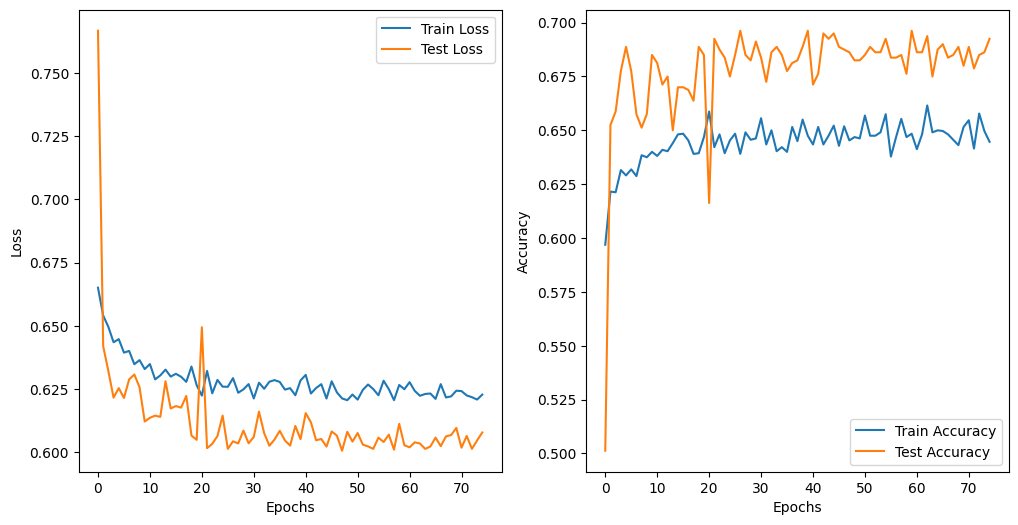

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_smiles
from torch.nn import Linear, BatchNorm1d, Dropout
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import optuna
import os
import random

# Set random seed for reproducibility
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_set()

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your dataset
df_final = pd.read_csv('/content/AID1578Sampled_4000_molecules_smiles.csv')

# Preprocess data and create graph list
graph_list = []
for i, smile in enumerate(df_final['SMILES']):
    try:
        g = from_smiles(smile)
        g.x = g.x.float()
        y_value = 1.0 if df_final['PUBCHEM_ACTIVITY_OUTCOME'][i] == 'Active' else 0.0
        y = torch.tensor(y_value, dtype=torch.float).view(1, -1)
        g.y = y
        graph_list.append(g)
    except Exception as e:
        print(f"Error processing SMILES {smile}: {e}")
        continue

# Stratified split of dataset into train and test sets
labels = [g.y.item() for g in graph_list]
train_dataset, test_dataset = train_test_split(graph_list, test_size=0.2, stratify=labels, random_state=50)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Vanilla GNN Model
class VanillaGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(VanillaGNN, self).__init__()
        self.fc1 = Linear(input_dim, hidden_dim)
        self.bn1 = BatchNorm1d(hidden_dim)
        self.fc2 = Linear(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm1d(hidden_dim)
        self.fc3 = Linear(hidden_dim, hidden_dim)
        self.bn3 = BatchNorm1d(hidden_dim)
        self.fc_out = Linear(hidden_dim, output_dim)
        self.dropout = Dropout(p=dropout_rate)

    def forward(self, data):
        x, batch = data.x, data.batch
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        return torch.sigmoid(self.fc_out(x))

# Training function
def train(model, loader, optimizer):
    model.train()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.binary_cross_entropy(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        preds = (out > 0.5).float()
        correct += (preds == data.y.view(-1, 1)).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
    accuracy = correct / len(loader.dataset)
    roc_auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    return total_loss / len(loader.dataset), accuracy, roc_auc, f1, kappa, precision, recall

# Testing function
@torch.no_grad()
def test(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []
    for data in loader:
        data = data.to(device)
        out = model(data)
        loss = F.binary_cross_entropy(out, data.y.view(-1, 1))
        total_loss += loss.item() * data.num_graphs
        preds = (out > 0.5).float()
        correct += (preds == data.y.view(-1, 1)).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
    accuracy = correct / len(loader.dataset)
    roc_auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    return total_loss / len(loader.dataset), accuracy, roc_auc, f1, kappa, precision, recall

# Optuna objective function for hyperparameter optimization
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    model = VanillaGNN(input_dim=9, hidden_dim=hidden_dim, output_dim=1, dropout_rate=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(20):
        train_loss, train_acc, _, _, _, _, _ = train(model, train_loader, optimizer)

    test_loss, test_acc, _, _, _, _, _ = test(model, test_loader)
    return test_acc

# Run Optuna for hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best hyperparameters from Optuna
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Initialize model with best hyperparameters
model = VanillaGNN(input_dim=9, hidden_dim=best_params["hidden_dim"], output_dim=1, dropout_rate=best_params["dropout_rate"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])

# Training loop with all metrics tracking
epochs = 75
score_train_loss, score_train_acc = [], []
score_test_loss, score_test_acc = [], []
score_roc_auc, score_f1, score_kappa = [], [], []
score_precision, score_recall = [], []

for epoch in range(epochs):
    train_loss, train_acc, train_roc_auc, train_f1, train_kappa, train_precision, train_recall = train(model, train_loader, optimizer)
    test_loss, test_acc, test_roc_auc, test_f1, test_kappa, test_precision, test_recall = test(model, test_loader)

    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)
    score_roc_auc.append(test_roc_auc)
    score_f1.append(test_f1)
    score_kappa.append(test_kappa)
    score_precision.append(test_precision)
    score_recall.append(test_recall)

    print(f'Epoch {epoch:03d}: Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, '
          f'ROC AUC: {test_roc_auc:.4f}, F1: {test_f1:.4f}, Kappa: {test_kappa:.4f}, '
          f'Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

# Plotting results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, label='Train Loss')
plt.plot(range(epochs), score_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, label='Train Accuracy')
plt.plot(range(epochs), score_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# prompt: give the best scores for each metric from above, train accuracy and test accuracy score ROC AUC, F1, kappa, precision, recall also

# Find the best scores for each metric
best_train_acc = max(score_train_acc)
best_test_acc = max(score_test_acc)
best_roc_auc = max(score_roc_auc)
best_f1 = max(score_f1)
best_kappa = max(score_kappa)
best_precision = max(score_precision)
best_recall = max(score_recall)

print(f"Best Train Accuracy: {best_train_acc:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")
print(f"Best ROC AUC: {best_roc_auc:.4f}")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best Kappa Score: {best_kappa:.4f}")
print(f"Best Precision: {best_precision:.4f}")
print(f"Best Recall: {best_recall:.4f}")

Best Train Accuracy: 0.6616
Best Test Accuracy: 0.6963
Best ROC AUC: 0.6963
Best F1 Score: 0.7163
Best Kappa Score: 0.3925
Best Precision: 0.7923
Best Recall: 0.9925
